CARGA DE LOS DATOS

In [ ]:
import pandas as pd

data = pd.read_excel("/content/Distritos.xlsx")

REGRESSION LASSO

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Identificamos variables categóricas y numéricas
categorical_vars = data.select_dtypes(include=['object']).columns.drop(['Distrito'])
numerical_vars = data.select_dtypes(exclude=['object']).columns.drop(['Pvp venta m^2', 'Pvp alquiler m^2'])

# Preparamos el preprocesamiento con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars),
        ('cat', OneHotEncoder(), categorical_vars)
    ])

# Definimos el modelo de regresión Lasso con búsqueda de hiperparámetros
lasso_model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Creamos pipeline con el preprocesamiento y el modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', lasso_model)])

# Separamos las características y la variable objetivo
X = data.drop(['Pvp venta m^2', 'Pvp alquiler m^2', 'Distrito'], axis=1)
y = data['Pvp venta m^2']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Predecimos y calculamos el error cuadrático medio en el conjunto de prueba
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred) # Calculando MSE
rmse = np.sqrt(mse)  # Calculando RMSE
r2 = r2_score(y_test, y_pred)  # Calculando R^2
from sklearn.metrics import mean_absolute_error
mae_lasso = mean_absolute_error(y_test, y_pred) #Calculando el MAE
mae_lasso


# Coeficientes más relevantes
coeficientes = pd.Series(lasso_model.coef_, index=preprocessor.transformers_[0][2].tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)))

# Filtramos coeficientes diferentes de cero
coeficientes_relevantes = coeficientes[coeficientes != 0].sort_values(key=abs, ascending=False)

# Mostramos el RMSE, el R^2 y los 10 coeficientes más relevantes
print("RMSE LASSO:", rmse)
print("R^2 LASSO:", r2)
print("MAE LASSO:", mae_lasso)

print("Coeficiente relevantes:",coeficientes_relevantes.head(10))


RMSE LASSO: 703.8881368825903
R^2 LASSO: 0.5615518675261866
MAE LASSO: 339.46495724134877
Coeficiente relevantes: Estudios superiores, licenciado, Arquitecto o Ingeniero, estudios superiores no universitarios, doctorado, estudios postgraduados    518.696273
Localizacion_MONCLOA-\nARAVACA                                                                                                      -359.274757
Localizacion_VILLA DE\n VALLECAS                                                                                                    -358.888724
Año                                                                                                                                  344.700402
Localizacion_SALAMANCA                                                                                                               333.869565
Tamaño Medio del hogar                                                                                                              -322.836859
Número de Parados (Jun

In [ ]:
# Predecimos los precios de venta por m^2 para todo el conjunto de datos
y_pred_full = pipeline.predict(X)

# Creamos un DataFrame para comparar los precios reales y predichos por distrito
comparison_df = pd.DataFrame({
    'Distrito': data['Distrito'],
    'Precio Real m^2': y,
    'Precio Predicho m^2': y_pred_full
})

# Agrupamos por distrito para obtener la media del precio real y predicho
comparison_df_grouped = comparison_df.groupby('Distrito').mean().reset_index()
comparison_df_grouped


,Distrito,Precio Real m^2,Precio Predicho m^2
0,PUENTE DE VALLECAS,1797.107143,1708.793719
1,ARGANZUELA,3805.576190,3838.215496
2,BARAJAS,3057.007143,3003.270171
3,CARABANCHEL,2068.390476,2038.002875
4,CENTRO,4682.554762,4620.315915
5,CHAMARTÍN,4824.236111,4908.771108
6,CHAMBERÍ,5043.233333,5000.486325
7,CIUDAD LINEAL,3273.126190,3322.926313
8,FUENCARRAL-EL PARDO,3308.592857,3520.664892
9,HORTALEZA,3512.873810,3557.546315


In [ ]:
pip install matplotlib seaborn


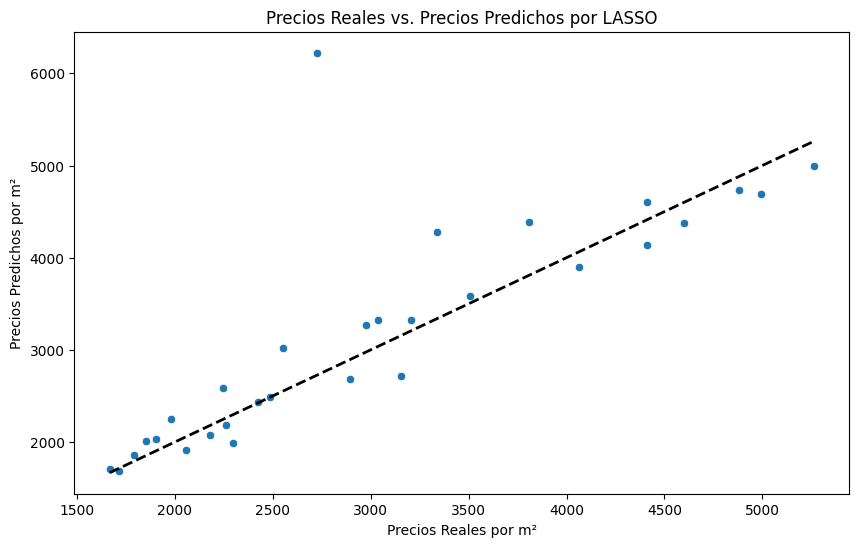

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'y_test' son nuestros valores reales y 'y_pred' las predicciones de tu modelo LASSO
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)  # Gráfico de dispersión de valores reales vs. predichos
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea para perfecta predicción
plt.title('Precios Reales vs. Precios Predichos por LASSO')
plt.xlabel('Precios Reales por m²')
plt.ylabel('Precios Predichos por m²')
plt.show()


REGRESION RIDGE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np

# Separamos variables independientes (X) y variable dependiente (y)
X = data.drop(['Pvp venta m^2'], axis=1)
y = data['Pvp venta m^2']

# Identificamos variables numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creamos transformadores para el preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Manejo de valores faltantes para numéricas
    ('scaler', StandardScaler())  # Estandarización
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Manejo de valores faltantes para categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combinamos transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Dividisión de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creacion y entrenamiento del modelo de regresión RIDGE dentro de un pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)

# Evaluación del modelo
y_pred = ridge_pipeline.predict(X_test)
# Calculo del MSE y RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse
# Calculo del coeficiente de determinación R^2
r2_score = ridge_pipeline.score(X_test, y_test)
# Calculo del MAE
mae_ridge = mean_absolute_error(y_test, y_pred)
mae_ridge

print("RMSE Ridge:", rmse)
print("R^2 Ridge:", r2_score)
print("MAE Ridge:", mae_ridge)


RMSE Ridge: 280.68753348583874
R^2 Ridge: 0.9302800316278701
MAE Ridge: 179.0795151455458


In [ ]:
# Predecimos el precio de venta por metro cuadrado para cada distrito usando el modelo entrenado
# Utilizaremos todos los datos disponibles ya que el objetivo es demostrar la capacidad del modelo con los datos actuales

y_pred_all = ridge_pipeline.predict(X)
data['Predicted Pvp venta m^2'] = y_pred_all

# Seleccionamos algunas columnas relevantes para visualizar los resultados, incluyendo el distrito y los precios reales y predichos
results = data[['Distrito', 'Pvp venta m^2', 'Predicted Pvp venta m^2']].drop_duplicates()
results
# Filtramos para mostrar únicamente una entrada por distrito para simplificar, asumiendo que los distritos pueden repetirse
# debido a diferentes años o tipos de datos en el conjunto original. Se mostrarán los promedios de los precios reales y predichos.
results_distinct = results.groupby('Distrito').agg({'Pvp venta m^2': 'mean', 'Predicted Pvp venta m^2': 'mean'}).reset_index()

# Aseguramos de que se muestran solo los 21 distritos únicos
results_distinct_21 = results_distinct.sort_values('Distrito').reset_index(drop=True)
results_distinct_21



,Distrito,Pvp venta m^2,Predicted Pvp venta m^2
0,PUENTE DE VALLECAS,1797.107143,1777.340867
1,ARGANZUELA,3805.576190,3861.391780
2,BARAJAS,3057.007143,3041.599044
3,CARABANCHEL,2068.390476,2062.703576
4,CENTRO,4682.554762,4682.676088
5,CHAMARTÍN,4824.236111,4823.095806
6,CHAMBERÍ,5043.233333,5090.495673
7,CIUDAD LINEAL,3273.126190,3276.097495
8,FUENCARRAL-EL PARDO,3308.592857,3437.002044
9,HORTALEZA,3512.873810,3565.380777


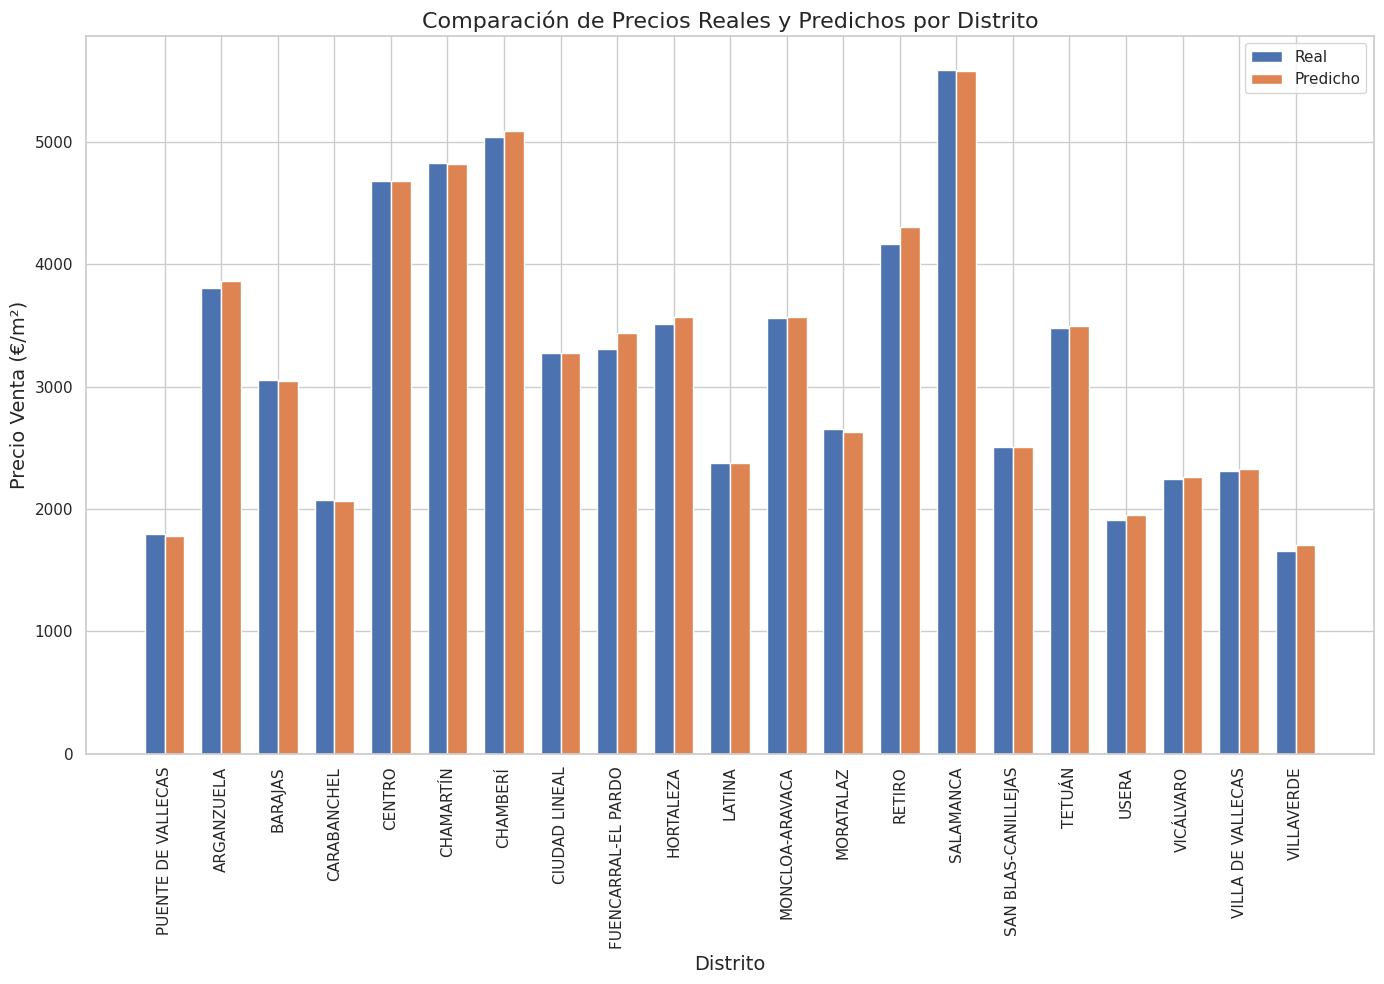

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración el estilo de los gráficos
sns.set(style="whitegrid")

# Creacion un gráfico de barras para comparar los precios reales y predichos por distrito
plt.figure(figsize=(14, 10))
bar_width = 0.35
index = results_distinct_21.index

# Barras para los precios reales
bars1 = plt.bar(index, results_distinct_21['Pvp venta m^2'], bar_width, label='Real')

# Barras para los precios predichos
bars2 = plt.bar(index + bar_width, results_distinct_21['Predicted Pvp venta m^2'], bar_width, label='Predicho')

plt.xlabel('Distrito', fontsize=14)
plt.ylabel('Precio Venta (€/m²)', fontsize=14)
plt.title('Comparación de Precios Reales y Predichos por Distrito', fontsize=16)
plt.xticks(index + bar_width / 2, results_distinct_21['Distrito'], rotation=90)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
# Calculamos la "rentabilidad" y añadir la columna correctamente
results_distinct_21['Rentabilidad (%)'] = ((results_distinct_21['Predicted Pvp venta m^2'] - results_distinct_21['Pvp venta m^2']) / results_distinct_21['Pvp venta m^2']) * 100

results_distinct_21


,Distrito,Pvp venta m^2,Predicted Pvp venta m^2,Rentabilidad (%)
0,PUENTE DE VALLECAS,1797.107143,1777.340867,-1.099894
1,ARGANZUELA,3805.576190,3861.391780,1.466679
2,BARAJAS,3057.007143,3041.599044,-0.504026
3,CARABANCHEL,2068.390476,2062.703576,-0.274943
4,CENTRO,4682.554762,4682.676088,0.002591
5,CHAMARTÍN,4824.236111,4823.095806,-0.023637
6,CHAMBERÍ,5043.233333,5090.495673,0.937144
7,CIUDAD LINEAL,3273.126190,3276.097495,0.090779
8,FUENCARRAL-EL PARDO,3308.592857,3437.002044,3.881082
9,HORTALEZA,3512.873810,3565.380777,1.494701


RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cargamos los datos
data_path = '/content/Distritos.xlsx'
data = pd.read_excel(data_path)

# Seleccionamos solo las variables numéricas
data_numeric = data.select_dtypes(include=['number'])

# Preparamos los datos para el modelo
X = data_numeric.drop(['Pvp venta m^2', 'Pvp alquiler m^2'], axis=1)  # Excluir la variable objetivo y otras no relevantes
y = data_numeric['Pvp venta m^2']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos un modelo de Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_scaled)

# Calculamos métricas para evaluar el modelo
# Calculo del MSE y RMSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse)
# Calculo del R^2
r2_rf = r2_score(y_test, y_pred_rf)
# Calculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_rf

print(rmse_rf, r2_rf, mae_rf)


280.68753348583874 0.6453121916639326 287.3572222088888


<ipython-input-12-57e025583f30>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


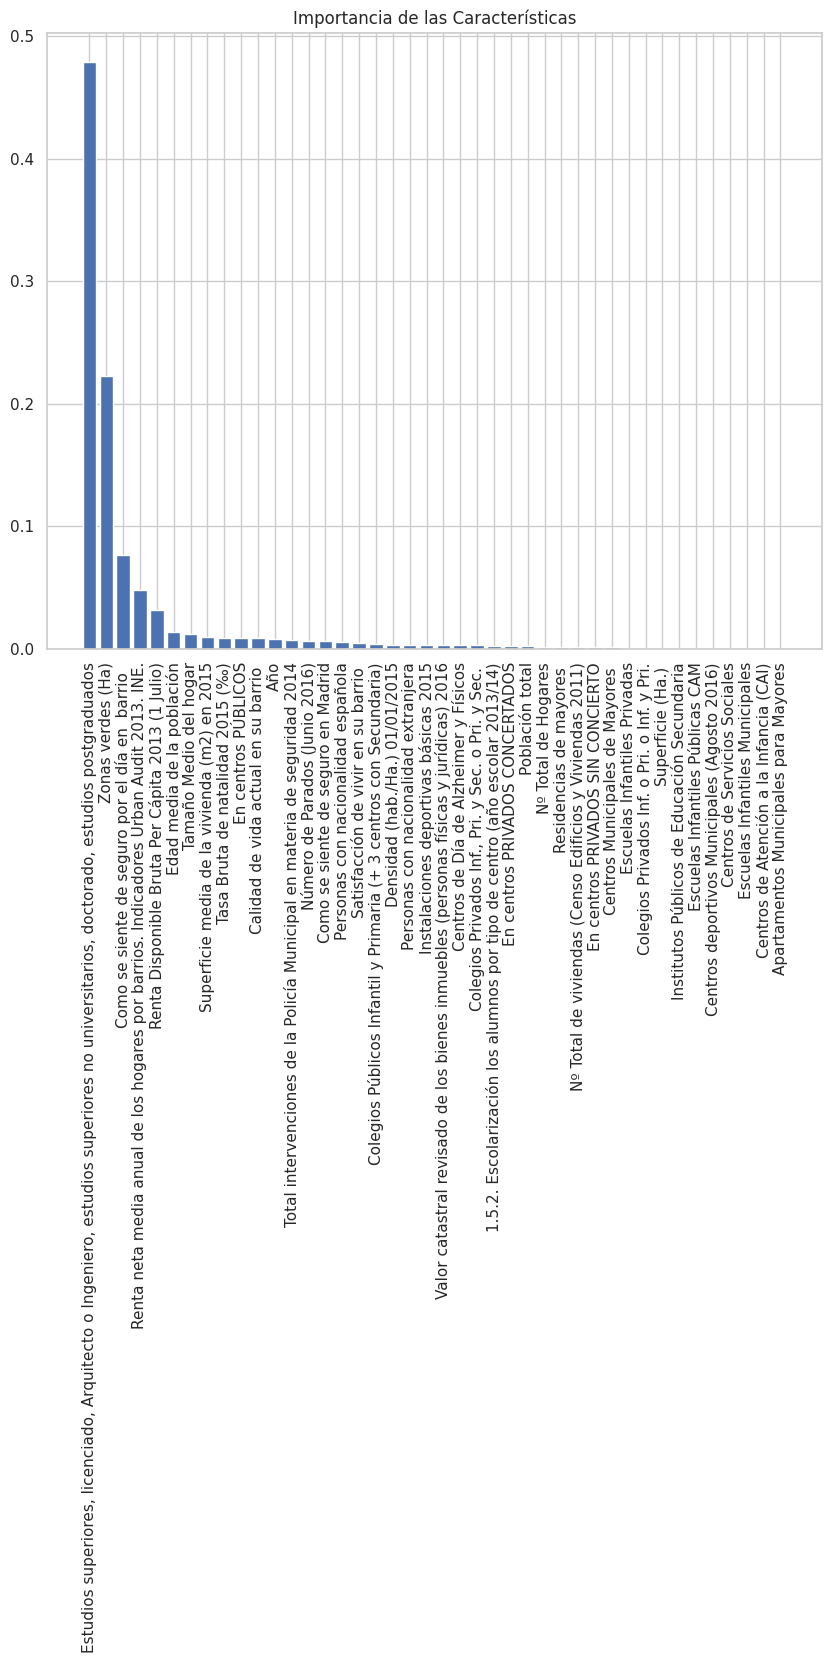

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Visualizamos la importancia de las características
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 8))
plt.title('Importancia de las Características')
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

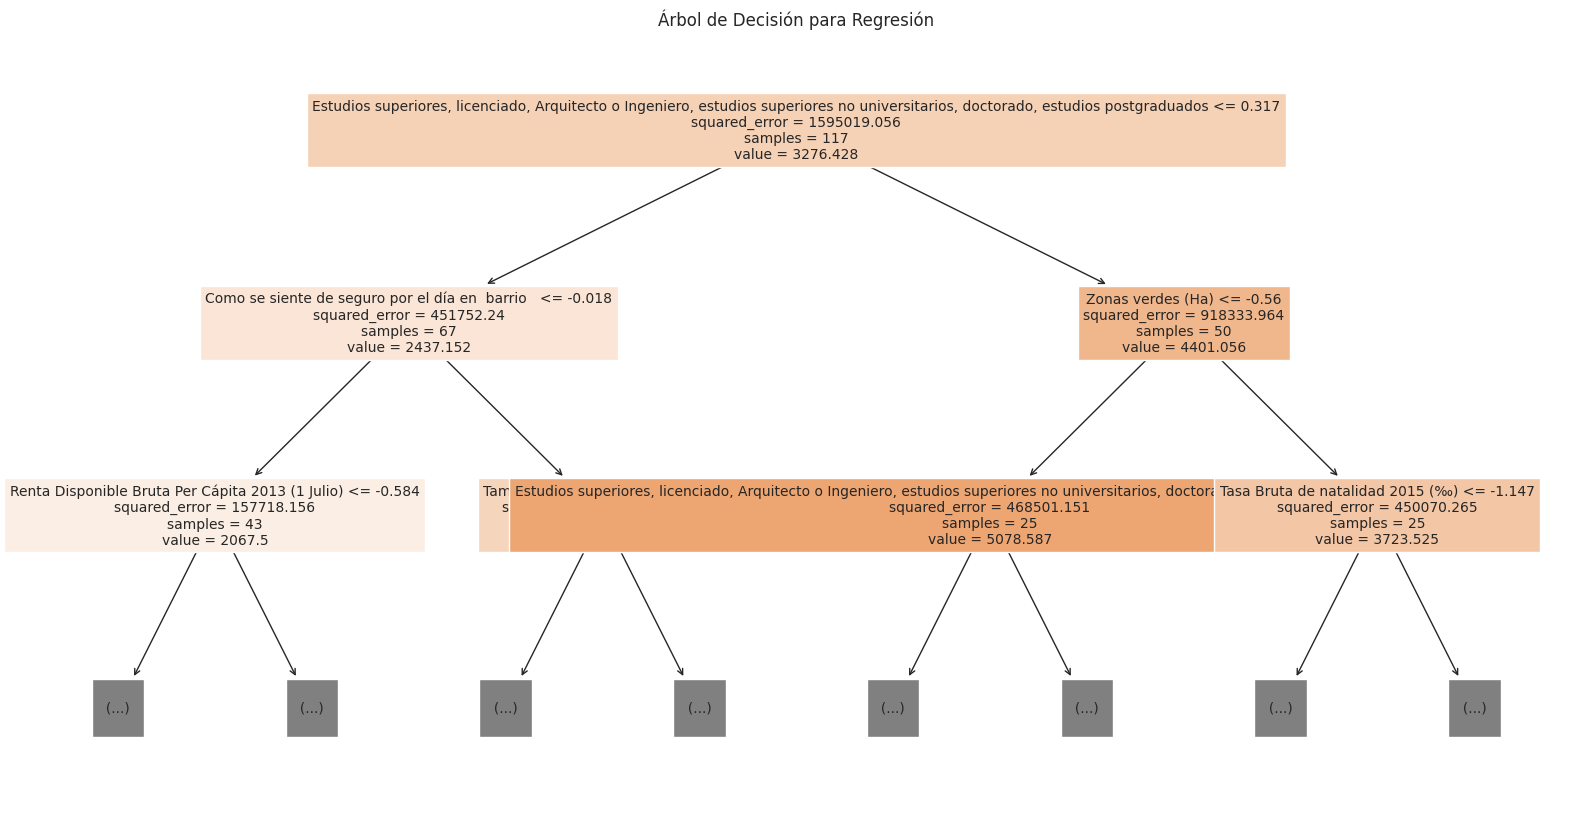

In [ ]:

# Preparación y muestra de un árbol de decisión básico
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_scaled, y_train)
plt.figure(figsize=(20,10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, max_depth=2, fontsize=10)
plt.title("Árbol de Decisión para Regresión")
plt.show()